<a href="https://colab.research.google.com/github/IAMPathak2702/Miscellaneous_machine_learning_project-/blob/main/Blood_Cell_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from keras import layers,Sequential
from keras.layers import BatchNormalization , Conv1D , Conv2D , Flatten , Dense
import os
import random
import pathlib


# Kaggle Dasaset Download and Unzipped

In [10]:
!chmod 600 /content/kaggle.json

In [11]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [12]:
!kaggle datasets download -d paultimothymooney/blood-cells

 88% 95.0M/108M [00:00<00:00, 116MB/s]
100% 108M/108M [00:01<00:00, 113MB/s] 


In [13]:
!unzip -q /content/blood-cells.zip

## Importing helperfunction and its functions

In [14]:
from myhelper_function import view_random_image , plot_hist_graph

# Preparing Dataset

In [15]:
TRAIN_DIR = "/content/dataset2-master/dataset2-master/images/TRAIN/"
TEST_DIR = "/content/dataset2-master/dataset2-master/images/TEST"
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

## Creating train and val datasets

In [16]:
# Create the training dataset
train_data = keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    image_size=IMAGE_SIZE,
    subset="training",
    validation_split=0.2,
    seed=42
)

# Create the validation dataset
val_data = keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    image_size=IMAGE_SIZE,
    subset="validation",
    validation_split=0.2,
    seed=42
)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


## Extracting Class Names

In [17]:
class_names = train_data.class_names
class_names

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

### Prefetching the datasets

In [34]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

# Visulising our data

In [39]:
# creating a fucntion to see batched image
def view_batched_image(train_ds, class_names , scaled = True):
    for images, labels in train_ds.take(1):
        # Convert labels to integer if necessary
        labels = np.argmax(labels, axis=-1)
        plt.figure(figsize=(20, 14))
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            # Rescale the images from [0, 1) to [0, 255] for visualization
            if scaled:
                plt.imshow(np.array(images[i].numpy()*255, dtype=np.uint8))
            else:
                plt.imshow(np.array(images[i].numpy(), dtype=np.uint8))
            plt.title(class_names[labels[i]])
            plt.axis("off")
        plt.show()



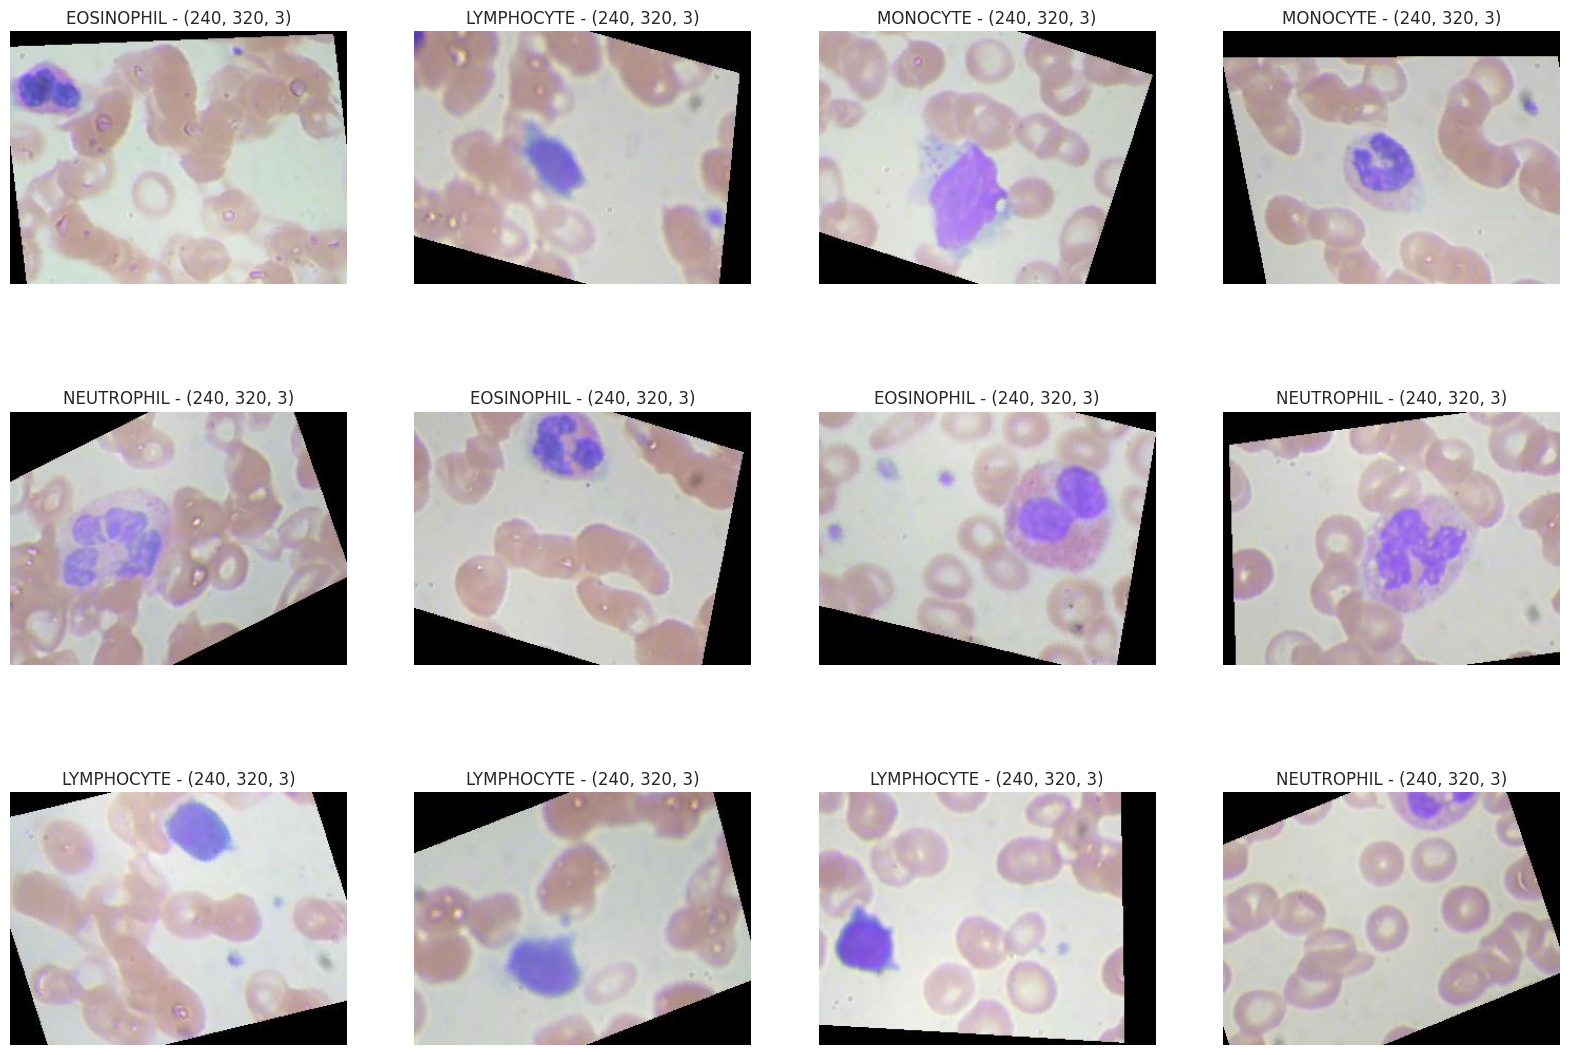

In [20]:
view_random_image(TRAIN_DIR , class_names);

## Adding Data augumentation to our data

In [26]:
data_augumentation_layers= keras.Sequential(
    [
        layers.Rescaling(1./255),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.2),
    ]
)


In [27]:
train_ds = train_data.map(lambda x, y: (data_augumentation_layers(x), y))
val_ds = val_data.map(lambda x, y: (data_augumentation_layers(x), y))

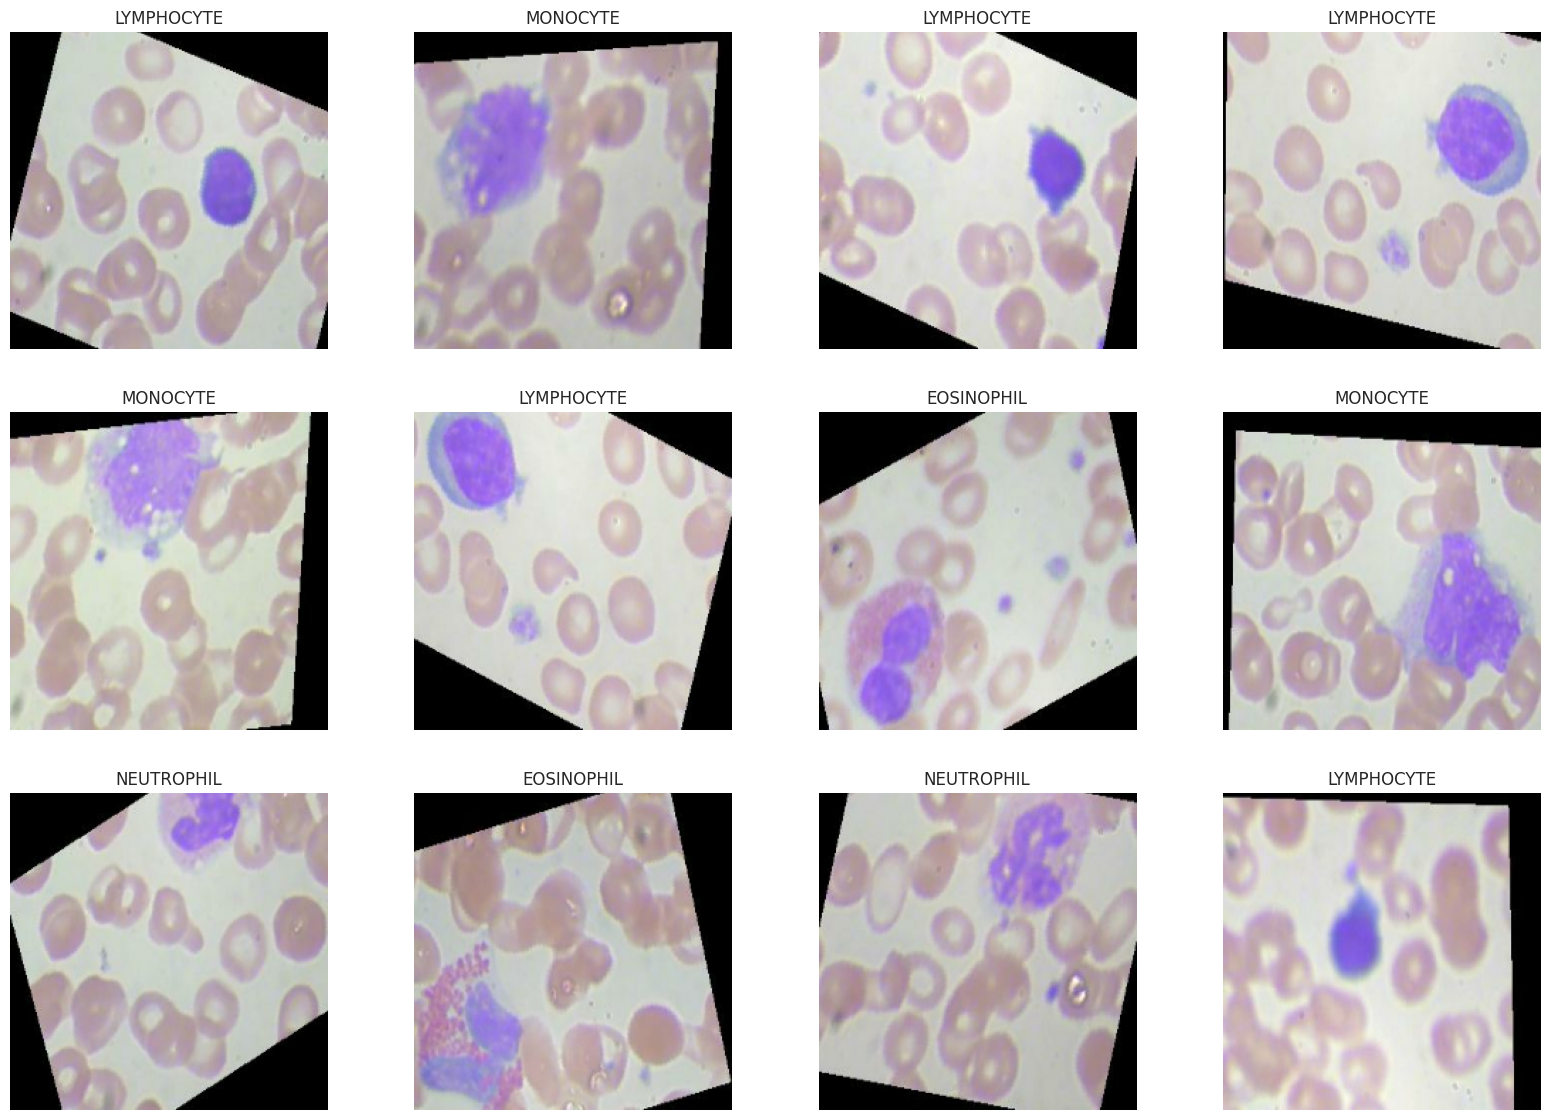

In [40]:
view_batched_image(train_data , class_names , scaled = False)

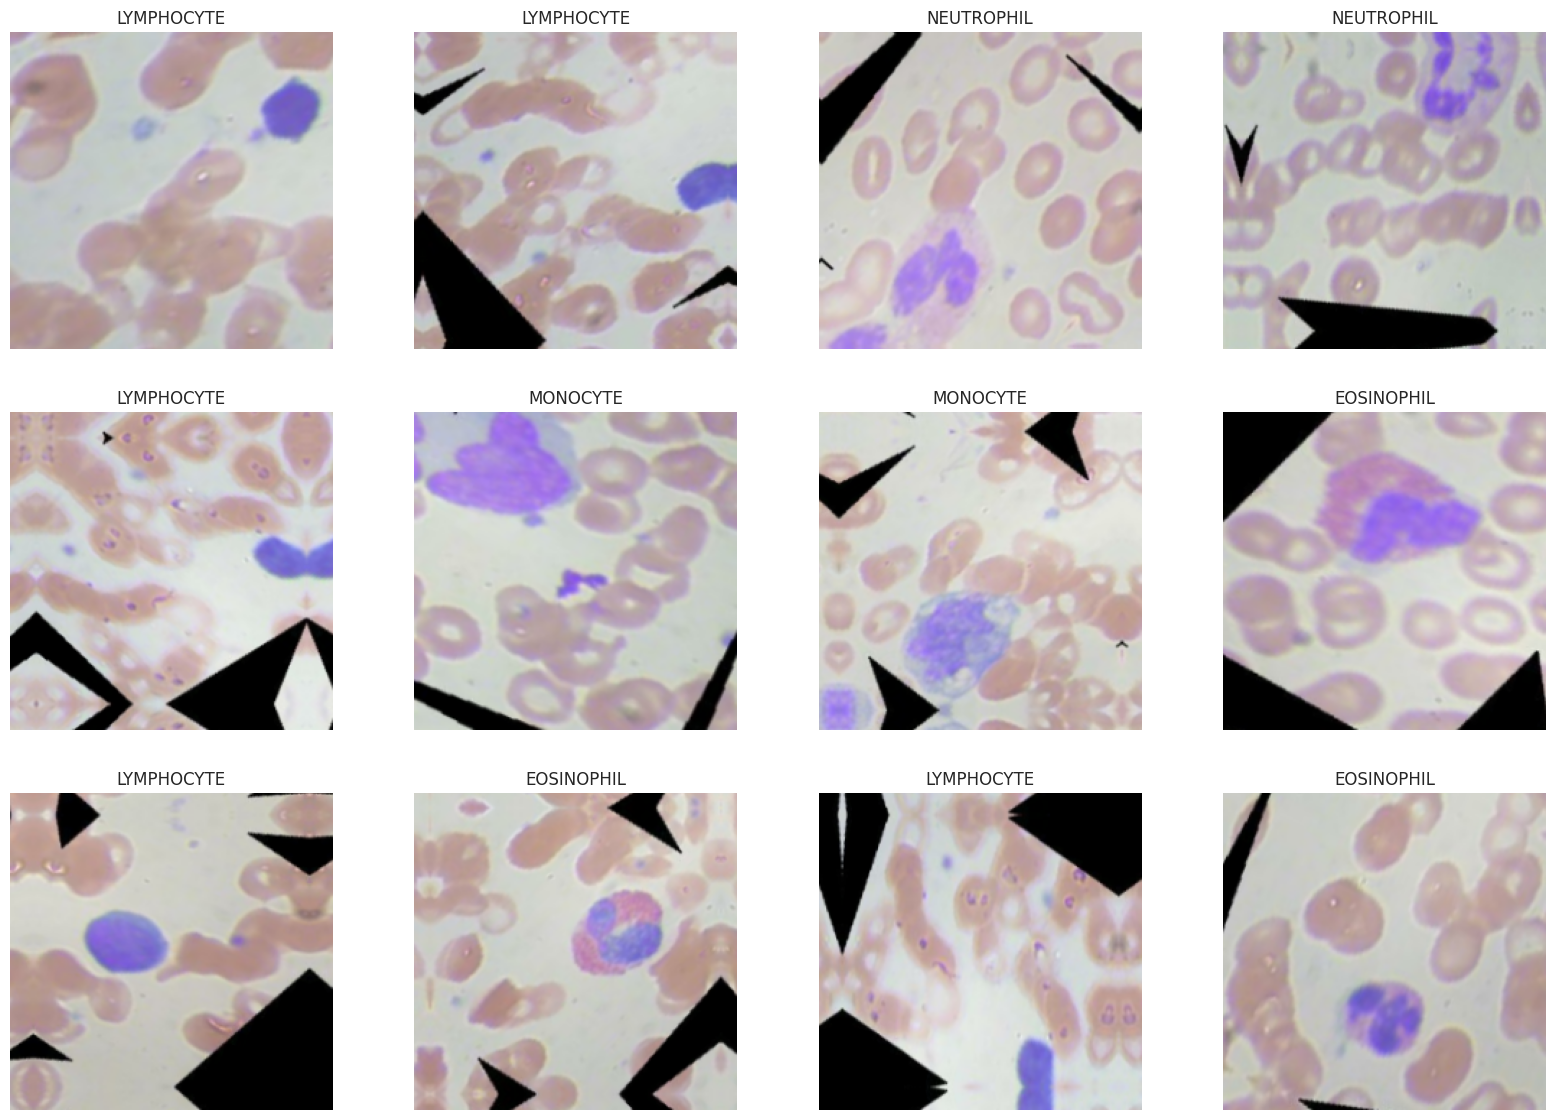

In [41]:
view_batched_image(train_ds , class_names)

# Importing Resnet50 and preparing a Model

In [30]:
from keras.applications import ResNet50

res = ResNet50(include_top = False , input_shape = (224,224,3))

for layer in res.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(res.output)

o = Dense(len(class_names),activation ="softmax" , name ="output_layer")(x)

res_model = keras.Model(res.input , o)

res_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

## MOdel.png

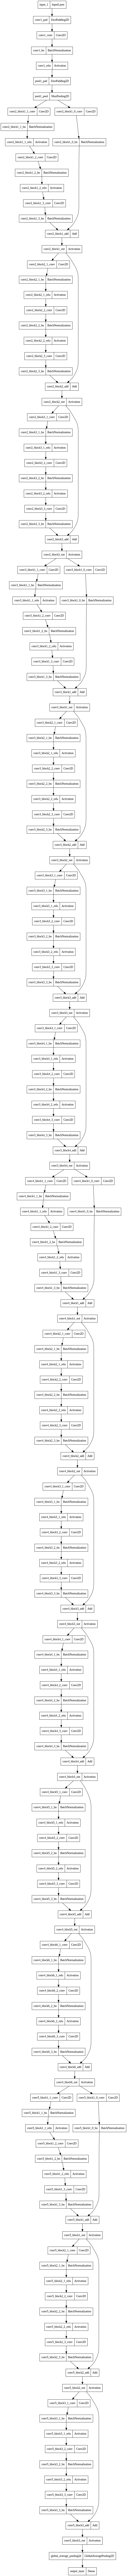

In [31]:
keras.utils.plot_model(res_model , )

## Compiling and Fitting the model with datasets
1. augumented dataset
2. non augumneted dataset

In [32]:
res_model.compile(loss = "categorical_crossentropy",
                  optimizer = 'adam',
                  metrics = ['accuracy'])

res_model.hist = res_model.fit(train_ds,
                               epochs = 5,
                               steps_per_epoch = len(train_ds),
                               validation_data = val_ds)

Epoch 1/5
249/249 [==============================] - 154s 570ms/step - loss: 1.4079 - accuracy: 0.2567 - val_loss: 1.4051 - val_accuracy: 0.2431
Epoch 2/5
249/249 [==============================] - 143s 572ms/step - loss: 1.4124 - accuracy: 0.2498 - val_loss: 1.3976 - val_accuracy: 0.2572
Epoch 3/5
249/249 [==============================] - 126s 507ms/step - loss: 1.4059 - accuracy: 0.2514 - val_loss: 1.4047 - val_accuracy: 0.2577
Epoch 4/5
249/249 [==============================] - 126s 504ms/step - loss: 1.4082 - accuracy: 0.2517 - val_loss: 1.3969 - val_accuracy: 0.2607
Epoch 5/5
249/249 [==============================] - 126s 507ms/step - loss: 1.4014 - accuracy: 0.2626 - val_loss: 1.3891 - val_accuracy: 0.2597


In [35]:
res_model_data_hist = res_model.fit(train_data,
                               epochs = 5,
                               steps_per_epoch = len(train_data),
                               validation_data = val_data)

Epoch 1/5
249/249 [==============================] - 61s 243ms/step - loss: 0.3682 - accuracy: 0.8835 - val_loss: 0.3921 - val_accuracy: 0.8689
Epoch 2/5
249/249 [==============================] - 56s 225ms/step - loss: 0.3377 - accuracy: 0.8988 - val_loss: 0.3700 - val_accuracy: 0.8810
Epoch 3/5
249/249 [==============================] - 62s 249ms/step - loss: 0.3145 - accuracy: 0.9053 - val_loss: 0.3684 - val_accuracy: 0.8850
Epoch 4/5
249/249 [==============================] - 67s 269ms/step - loss: 0.2977 - accuracy: 0.9112 - val_loss: 0.3329 - val_accuracy: 0.8880
Epoch 5/5
249/249 [==============================] - 64s 258ms/step - loss: 0.2841 - accuracy: 0.9112 - val_loss: 0.3330 - val_accuracy: 0.8925


In [43]:
res_model.evaluate(val_data)

63/63 [==============================] - 13s 201ms/step - loss: 0.3330 - accuracy: 0.8925


[0.33295533061027527, 0.8925163149833679]

## Saving the model

In [38]:
res_model.save("/content/drive/MyDrive/tensorflow_model/Blood_cell_image_resnet50/")

## Evaluating the loaded model

In [44]:
loaded_res_model = keras.models.load_model("/content/drive/MyDrive/tensorflow_model/Blood_cell_image_resnet50/")
loaded_res_model.evaluate(val_data)

63/63 [==============================] - 12s 164ms/step - loss: 0.3330 - accuracy: 0.8925


[0.33295533061027527, 0.8925163149833679]